In [1]:
%load_ext autoreload
%autoreload 2

from abc import ABC

import jax
import jax.numpy as jnp
import diffrax
import equinox as eqx
from jaxtyping import Array, Float

jax.config.update("jax_enable_x64", True)


import orc
import orc.utils.visualization as vis
from orc.models import CESNForecaster
from orc.drivers import DriverBase
from orc.embeddings import EmbedBase
from orc.readouts import ReadoutBase
from orc.drivers import ESNDriver
from orc.readouts import LinearReadout, QuadraticReadout
from orc.embeddings import LinearEmbedding
from orc.rc import RCForecasterBase

## Data 

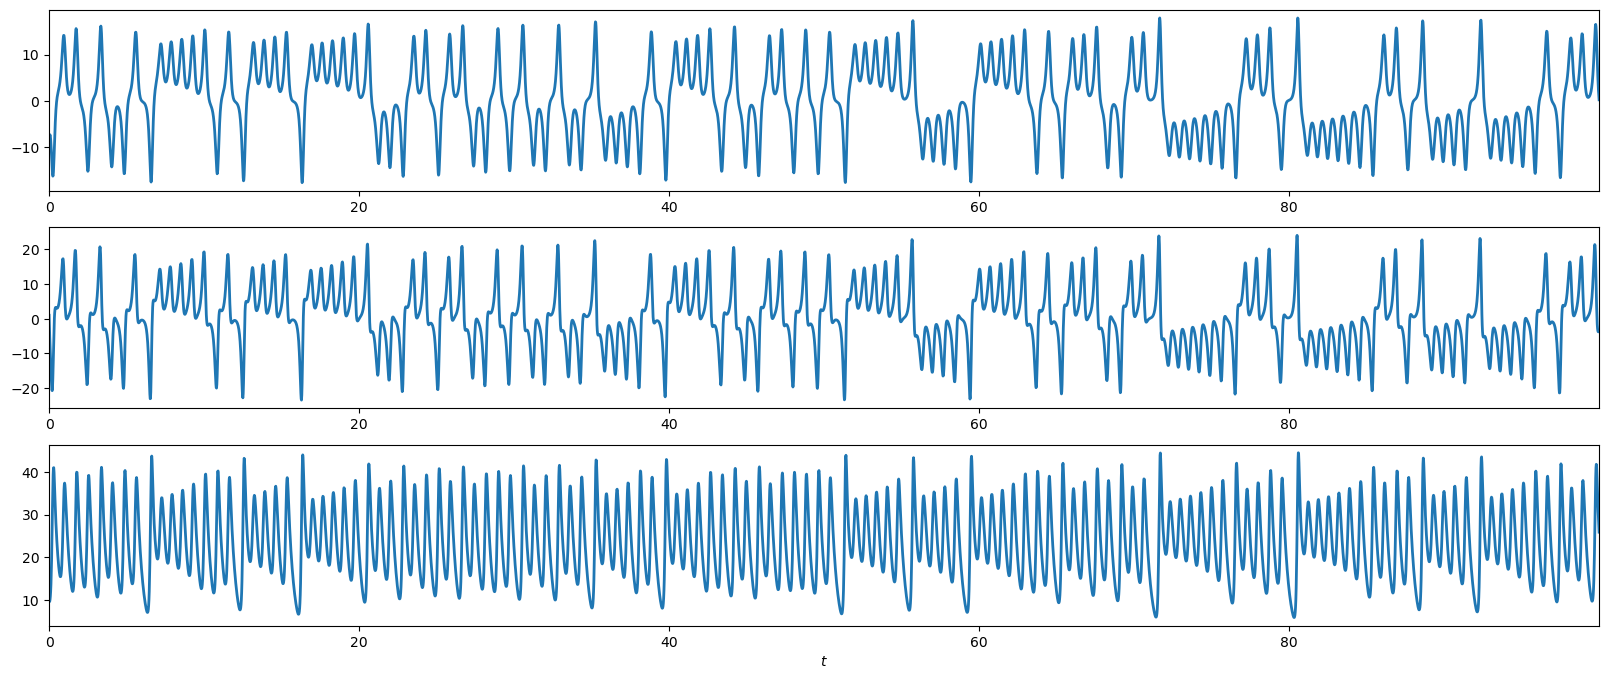

Train shape: (4000, 3), Test shape: (1000, 3)


In [2]:
tN = 100.0
dt = 0.02
test_perc = 0.2
U, t = orc.data.lorenz63(tN=tN, dt=dt)
vis.plot_time_series(U, t)

# train test split
split_idx = int((1 - test_perc) * U.shape[0])
U_train = U[:split_idx]
U_test = U[split_idx:]
t_train = t[:split_idx]
t_test = jnp.arange(U_test.shape[0]) * dt

print(f"Train shape: {U_train.shape}, Test shape: {U_test.shape}")

## Train it (Continuous)

In [3]:
esn = orc.models.CESNForecaster(data_dim=U_train.shape[1], res_dim=200, time_const=50.0)
esn, R = orc.models.train_CESNForecaster(model=esn, train_seq=U_train, t_train=t_train)

In [4]:
print(jnp.linalg.norm(esn.readout.wout))

496.2336603501711


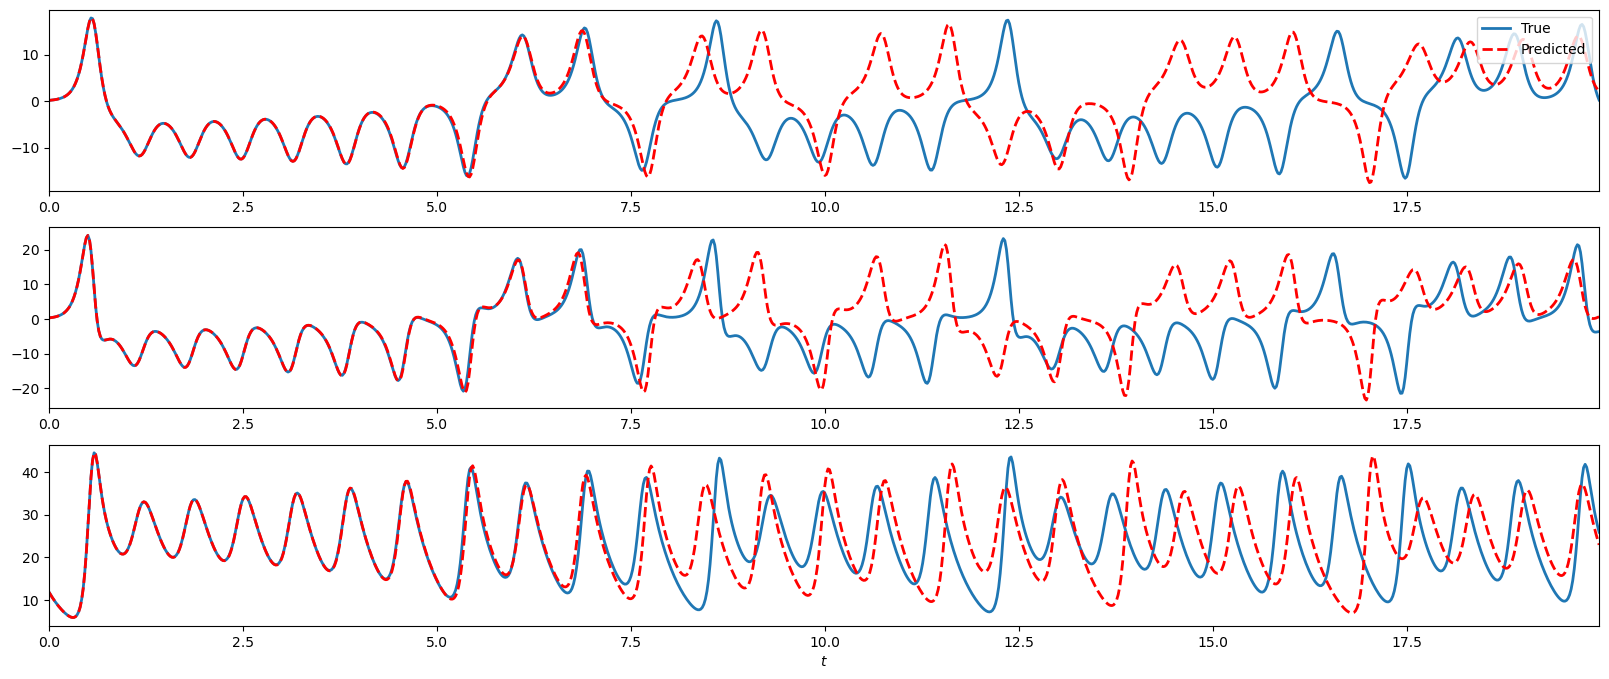

In [5]:
U_pred = esn.forecast(ts=t_test, res_state=R[-1])

vis.plot_time_series(
    [U_test, U_pred],
    t_test,
    line_formats=["-", "r--"],
    time_series_labels=["True", "Predicted"],
)